In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info import Operator
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import plot_histogram
from IPython.display import display, Math, Latex
import math

# Quantum Phase Estimation


Given a unitary operator $U$ we want to find the solution $\theta$ to the eigenvalue $\lambda$ problem defined by the eigenvector identity $U|\psi\rangle = \lambda|\psi\rangle$, where $|\psi\rangle$ is an eigenvector of $U$, and $\lambda = e^{2\pi i\theta}$. Hence, our problem consists into solving the following equation

$$
U|\psi\rangle = e^{2\pi i\theta_{\psi}}|\psi\rangle
$$

Which more precisely is: How can we extract the $\theta_{\psi}$ parameter given the ability to prepare $|\psi\rangle$ and apply the unitary operator $U$.

The Quantum Phase Estimation is pretty useful for us, since the evolution of a Hamiltonian (real systems evolution over time) is unitary, which give us a important tool for quantum simulations.

Before we start, I strongly recommend for those that are not familiar with the QFT to read the notebook about Quantum Fourier Transforms.

## The Circuit

#### CIRCUIT IMAGE

We can see how the quantum phase estimation works with a simple example represented by the circuit above, where given a input $|x\rangle = |0\rangle|\psi\rangle$ we have the following algorithm steps.

**Step 0.** At first, as already mentioned we initialize our circuit with a state
$$
    \begin{align*}
    |x_0\rangle = |0\rangle|\psi\rangle
    \end{align*}
$$

**Step 1.** Then we apply a Hadamard gate on the first Qubit, where we get a superposition state given by

$$
    \begin{align*}
    |x_1\rangle &= H|0\rangle|\psi\rangle\\
                &= \frac{1}{\sqrt{2}}\big(|0\rangle + |1\rangle\big)|\psi\rangle\\
                &= \frac{1}{\sqrt{2}}\big(|0\rangle|\psi\rangle + |1\rangle|\psi\rangle\big)\\
    \end{align*}
$$

**Step 2.** After, by applying a $x$ Controlled $U$ gate onto our $|\psi\rangle$ eigenstate we have that 

$$
    \begin{align*}
    |x_2\rangle &= \frac{1}{\sqrt{2}}\big(|0\rangle|\psi\rangle + e^{2\pi i\theta_{\psi}}|1\rangle|\psi\rangle\big)\\
    \end{align*}
$$

**Step 3.** Finally, another Hadamard gate is applied to the first qubit giving us our final state

$$
    \begin{align*}
    |x_2\rangle &= \frac{1}{\sqrt{2}}\bigg(\bigg(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\bigg)|\psi\rangle + e^{2\pi i\theta_{\psi}}\bigg(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\bigg)|\psi\rangle\bigg)\\
                &= \frac{1}{2}\bigg(|0\rangle\big(1 + e^{2\pi i\theta_{\psi}}\big) + |1\rangle\big(1 - e^{2\pi i\theta_{\psi}}\big)\bigg)
    \end{align*}
$$

**Step 4.** And from this last equation we have that the two possible outcomes from a measurement on the first qubit of our circuit quantum state are 

$$
    \begin{align*}
    \text{Prob. of measuring } |0\rangle \Longrightarrow \frac{1}{2}\bigg| \big(1 + e^{2\pi i\theta_{\psi}}\big)\bigg|^2\\
    \text{Prob. of measuring } |1\rangle \Longrightarrow \frac{1}{2}\bigg| \big(1 - e^{2\pi i\theta_{\psi}}\big)\bigg|^2\\
    \end{align*}
$$

By this simple experiment we can extract $e^{i\theta}$, however its precision may not be as good as wish, but using more qubits we can get a better approximation for our problem.

In order to do the this we only need to generalize the steps above to a string of $n$ ancilla qubits $|0\rangle^{\otimes n}$, so we rewrite our initial state as $|x\rangle = |0\rangle^{\otimes n}|\psi\rangle$ and build a new circuit as follows

#### CIRCUIT IMAGE

**Step 0.** Initialize the circuit with our $|x\rangle$ state, so that $|x_0\rangle = |0\rangle^{\otimes n}|\psi\rangle$

**Step 1.** Apply Hadamard Gates to the ancilla qubits to get our superposition state

$$
    \begin{align*}
        |x_1\rangle &= H^{\otimes n}|0\rangle^{\otimes n}|\psi\rangle\\
                    &= \frac{1}{\sqrt{2^n}}\big(|0\rangle + |1\rangle\big)^{\otimes n}|\psi\rangle\\
                    &= \frac{1}{\sqrt{2^n}}\sum_{\text{k} = 1}^{2^n - 1} |\text{k}\rangle |\psi\rangle
    \end{align*}
$$

**Step 2.** Now applying our $\text{k}$ controlled $U$ gates into our state we have that

$$
    \begin{align*}
        |x_2\rangle &= H^{\otimes n}|0\rangle^{\otimes n}|\psi\rangle\\
                    &= \frac{1}{\sqrt{2^n}}\big(|0\rangle + |1\rangle\big)^{\otimes n}|\psi\rangle\\
                    &= \frac{1}{\sqrt{2^n}}\bigg(\big(|0\rangle + e^{2\pi i\theta_{\psi}2^{n-1}}\big) \otimes \big(|0\rangle + e^{2\pi i\theta_{\psi}2^{n-2}}|1\rangle\big) \otimes \dots \otimes \big(|0\rangle + e^{2\pi i\theta_{\psi}2^{0}}|1\rangle\big)\bigg)\\
                    &= \frac{1}{\sqrt{2^n}}\sum_{\text{k} = 1}^{2^n - 1} e^{2\pi i\theta_{\psi} \text{k}}|\text{k}\rangle |\psi\rangle\\
    \end{align*}
$$

**Step 3.** In the example above we used a Hadamard Gate to give us the final state to be measured, however it was a single ancilla qubit circuit, and for $n = 1$ the $\mathrm{QFT}^{\dagger}$ is exactly equal to the single qubit Hadamard Gate transform. And we know that the $\mathrm{QFT}$ applied to a equal superposition state on $n$ qubits $|\text{w}\rangle$ give us 

$$
    \begin{align*}
         |x\rangle = QFT|\text{w}\rangle &= \frac{1}{\sqrt{2^n}}\sum_{\text{k} = 1}^{2^{n}-1}e^{\frac{2\pi \text{w}i\text{k}}{2^\text{k}}}|\text{k}\rangle\\
         &= \frac{1}{\sqrt{2^n}}\bigg(\big(|0\rangle + e^{{\frac{2\pi ik}{2^1}}}|1\rangle\big)\otimes\big(|0\rangle + e^{{\frac{2\pi ik}{2^2}}}|1\rangle\big)\otimes\big(|0\rangle + e^{{\frac{2\pi ik}{2^3}}}|1\rangle\big)\otimes\dots\otimes\big(|0\rangle + e^{{\frac{2\pi ik}{2^n}}}|1\rangle\big)\bigg)\\
    \end{align*}
$$

We can notice that the final equation on **Step 2** $|x_2\rangle$ is equal to the result above up by a factor $2^n\theta_{\psi}$.

Therefone, applying the Inverse Quantum Fourier Transform $\text{QFT}^\dagger$, by measuring our final state we get an expected output of $|x_3\rangle = |2^n\theta_\psi\rangle$, and our final answer
$$
    \theta_\psi = \frac{x_3}{2^n} 
$$

### S-Gate Phase Estimation

Now, lets define the circuit to estimate the phase of the $S$-Gate or pauli-$Z^{1/2}$, which is given by the following matrix

$$
    S = \begin{bmatrix}
    1 & 0\\
    0 & i
    \end{bmatrix}
$$
which should induce a $\frac{\pi}{2}$ phase, with $\theta = \frac{1}{4}$.

$$
    S|1\rangle = e^{2\pi i\theta}|1\rangle
$$

In [252]:
#INVERSE QFT FUNCTION (WITH SWAPS)
def reflect(mcq, n):
    for i in range(int(n/2)):
        mcq.swap(i, n-i-1)

def myInverseQFT(mcq, n):
    for x_k in range(n):
        for x_j in range(x_k):
            angle = -math.pi/float(2**(x_k-x_j))
            mcq.cu1(angle, x_j, x_k)
        mcq.h(x_k)

#APPLY THE CONTROLLED U GATES
def build(mcq, n):
    m = 1
    for k in range(n):
        for i in range(m):
            mcq.cu1(math.pi/2, k, n)
        m *= 2

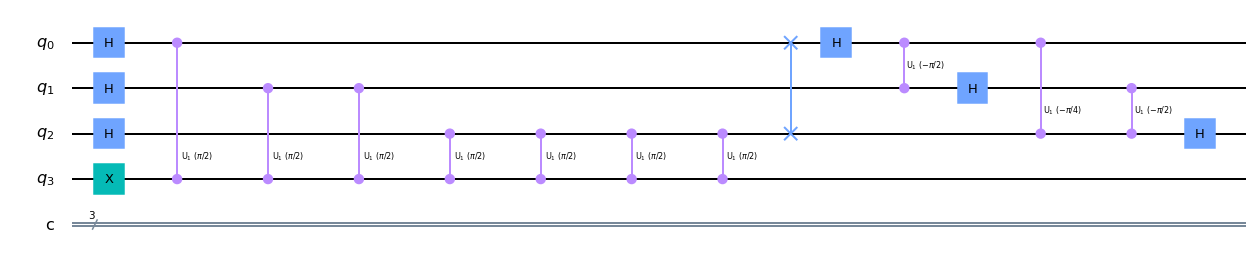

In [256]:
n = 3
qpe = QuantumCircuit(n+1, n)
qpe.x(n)
qpe.h(range(n))

build(qpe, n)
reflect(qpe, n)
myInverseQFT(qpe, n)

qpe.draw('mpl')

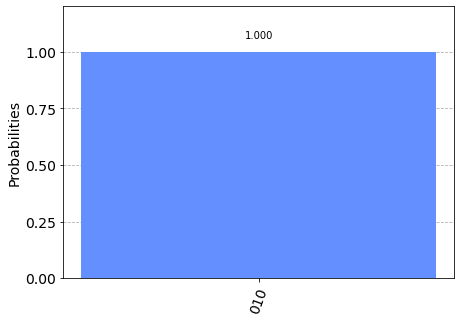

In [260]:
qpe.measure(range(n), range(n))
results = execute(qpe, backend=Aer.get_backend('qasm_simulator'), shots=2048).result()
ans = results.get_counts()
plot_histogram(ans)

And as expected the result is exactly equal to $\theta = \frac{2}{2^{3}} = \frac{1}{4}$.

## References

__[Learn Quantum Computation using Qiskit](https://community.qiskit.org/textbook/)__\
__[Quantum Phase Estimation Qiskit](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)__